# Instalando e importando bibliotecas

Pode gerar um aviso de conflito pelo colab, mas é só seguir normalmente.

In [11]:
!pip install pycaret

In [2]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import itertools
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
from pycaret.regression import *

# Carregando e explorando dados

A ideia aqui é dar uma olhada geral bem rápida. Como o dataset é pequeno, podemos fazer uma seleção de características iterando por todas as possibilidades mais a frente.O principal foi perceber que todos os dados são numéricos, não há valores ausentes (NA) e que a distribuição de algumas colunas está bem enviesada.Aqui, testamos algumas transformações para centralizar os dados, facilitando a interpretação do modelo, e decidimos pela Box-Cox.

In [3]:
# Carrega o dataset California Housing
housing = fetch_california_housing()

# Converte para um DataFrame do pandas
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target  # Adiciona a coluna alvo (MedHouseVal)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


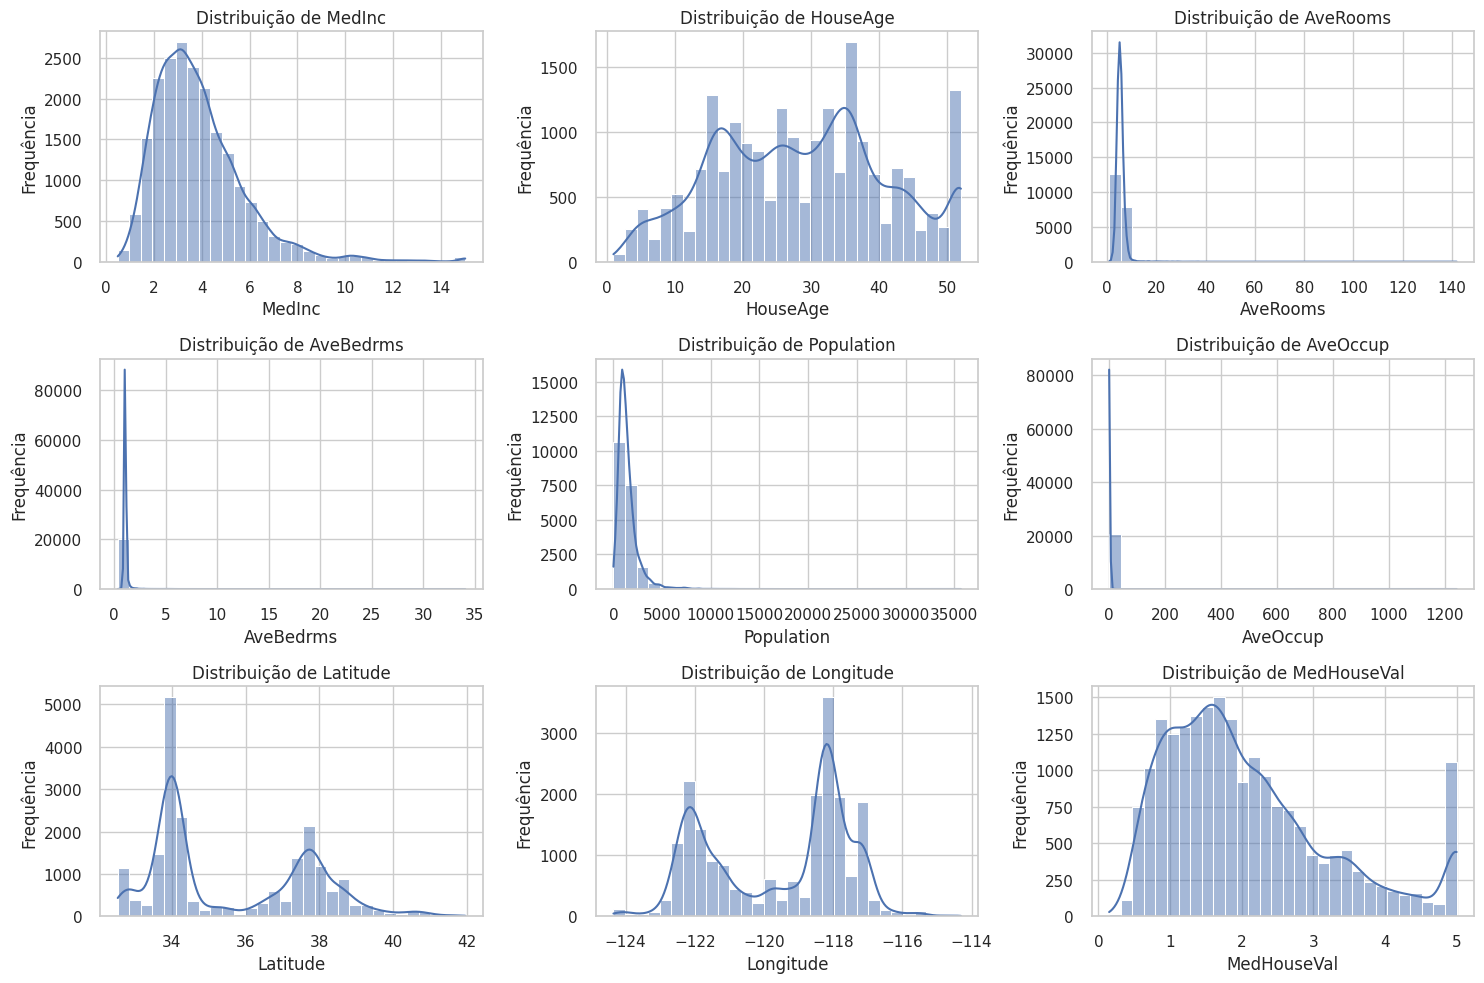

In [6]:
# Configurando o estilo dos gráficos
sns.set(style="whitegrid")

# Visualizando as distribuições
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribuição de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

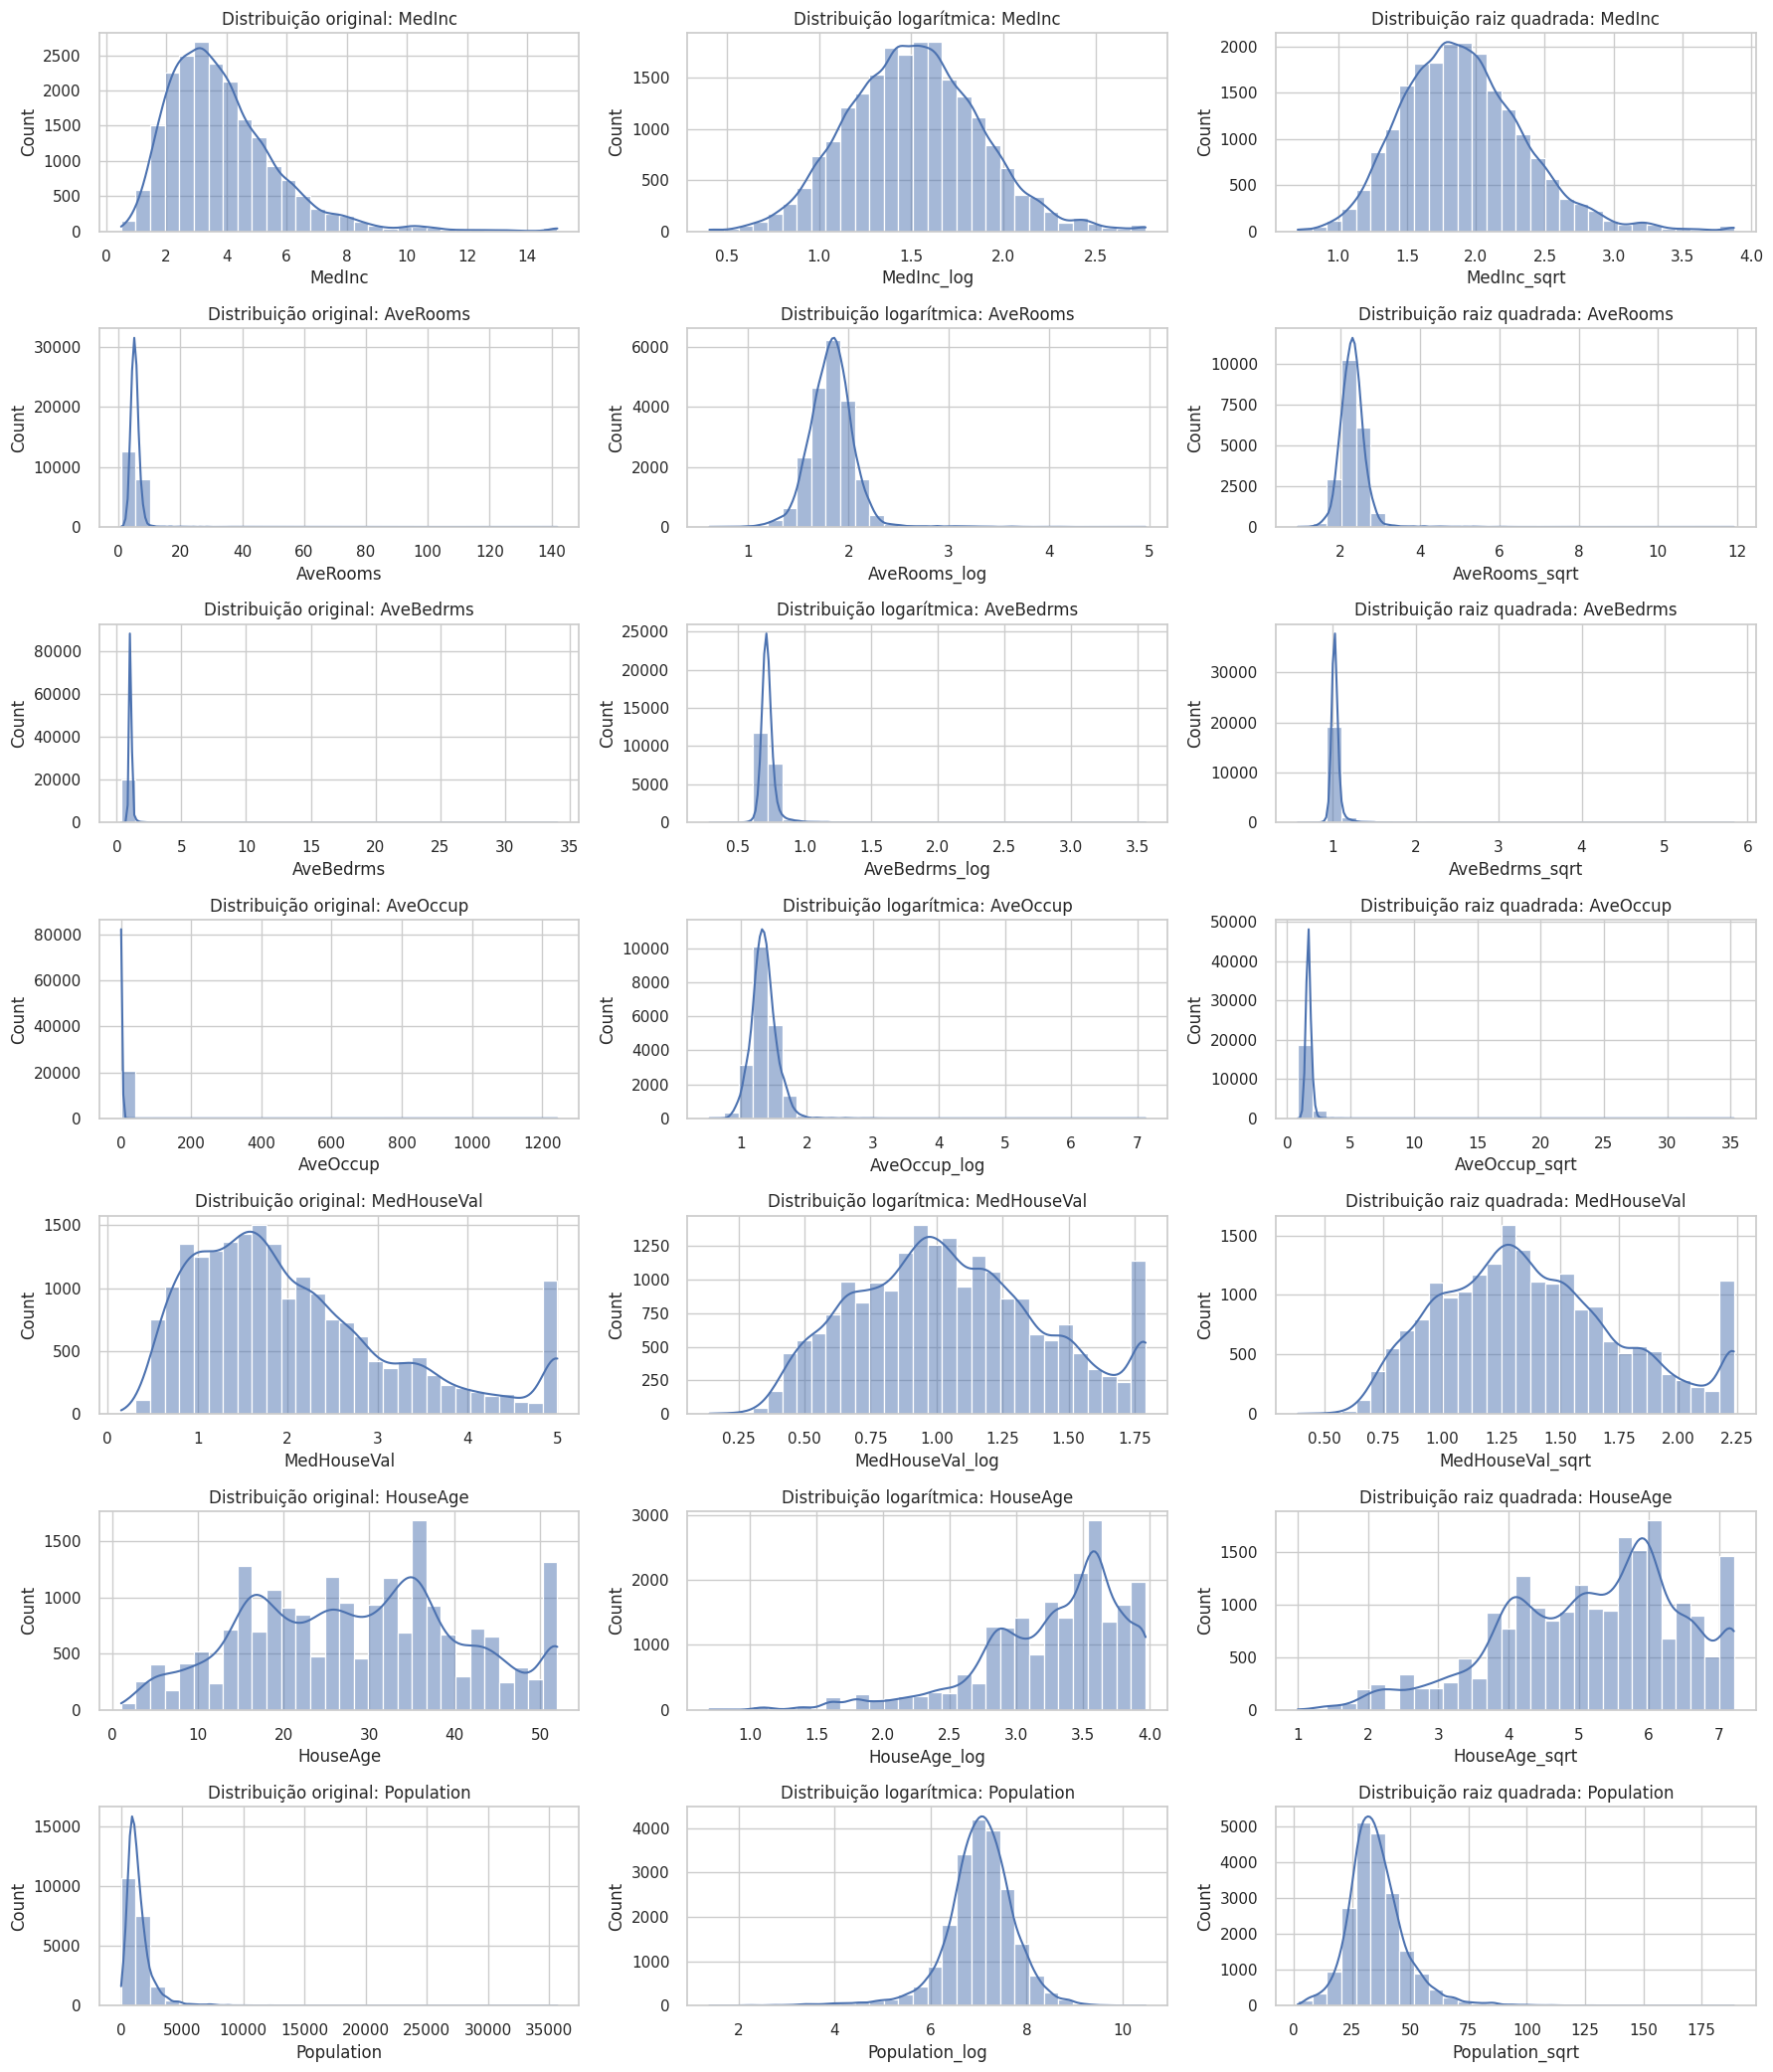

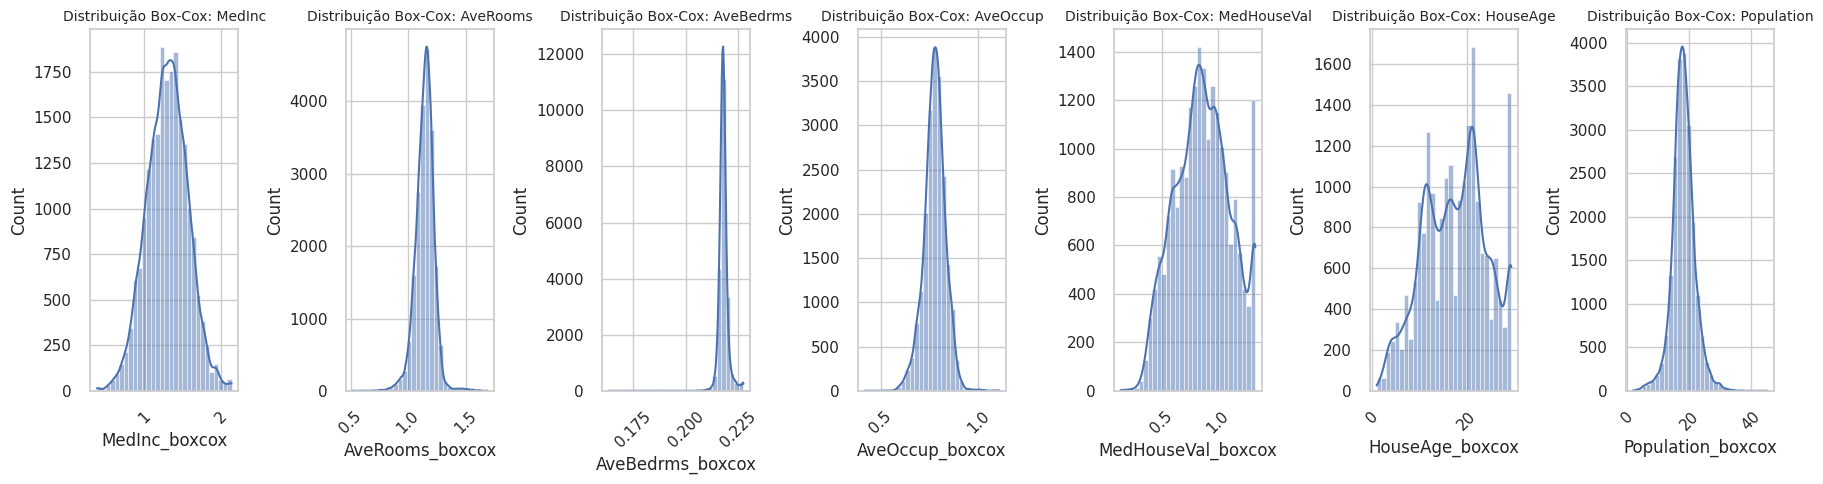

In [7]:
# Definindo as colunas a serem transformadas
columns_to_transform = ['MedInc', 'AveRooms', 'AveBedrms', 'AveOccup', 'MedHouseVal', 'HouseAge', 'Population']

# Criando o DataFrame para armazenar as transformações
transformed_data = pd.DataFrame()

# Aplicando a transformação logarítmica
for column in columns_to_transform:
    transformed_data[f'{column}_log'] = np.log1p(df[column])

# Aplicando a transformação pela raiz quadrada
for column in columns_to_transform:
    transformed_data[f'{column}_sqrt'] = np.sqrt(df[column])

# Aplicando a transformação Box-Cox (somando 1 para evitar valores zero)
for column in columns_to_transform:
    transformed_data[f'{column}_boxcox'], _ = stats.boxcox(df[column] + 1)

# Criando gráficos para visualizar as distribuições
plt.figure(figsize=(18, 21))  # Ajustando o tamanho da figura para acomodar os gráficos
for i, column in enumerate(columns_to_transform, 1):
    plt.subplot(7, 3, i * 3 - 2)  # 7 linhas e 3 colunas para acomodar todos os gráficos
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribuição original: {column}')

    plt.subplot(7, 3, i * 3 - 1)  # 7 linhas e 3 colunas para acomodar todos os gráficos
    sns.histplot(transformed_data[f'{column}_log'], bins=30, kde=True)
    plt.title(f'Distribuição logarítmica: {column}')

    plt.subplot(7, 3, i * 3)  # 7 linhas e 3 colunas para acomodar todos os gráficos
    sns.histplot(transformed_data[f'{column}_sqrt'], bins=30, kde=True)
    plt.title(f'Distribuição raiz quadrada: {column}')

plt.tight_layout()
plt.show()

# Gráficos Box-Cox
plt.figure(figsize=(18, 5))  # Ajustando o tamanho da figura para os gráficos Box-Cox
for i, column in enumerate(columns_to_transform, 1):
    plt.subplot(1, 7, i)  # 1 linha e 7 colunas para os gráficos Box-Cox
    sns.histplot(transformed_data[f'{column}_boxcox'], bins=30, kde=True)
    plt.title(f'Distribuição Box-Cox: {column}', fontsize=10)  # Ajuste no tamanho da fonte, se necessário
    plt.xticks(rotation=45)  # Girando os rótulos do eixo X em 45 graus
plt.tight_layout()
plt.show()

In [8]:
def apply_boxcox_transformation(df, columns):
    """Aplica a transformação Box-Cox nas colunas especificadas."""
    for column in columns:
        # Garantir que os dados sejam positivos antes de aplicar Box-Cox
        if (df[column] + 1).min() > 0:  # Verificando se todos os valores são positivos
            df[column], _ = stats.boxcox(df[column] + 1)  # Adicionando 1 para evitar valores negativos
        else:
            print(f"A transformação Box-Cox não pode ser aplicada à coluna {column} porque contém valores negativos ou zero.")
    return df

# Colunas selecionadas para aplicar a transformação Box-Cox
columns_to_transform = ['MedInc', 'AveRooms', 'AveBedrms', 'AveOccup', 'MedHouseVal', 'HouseAge', 'Population']

# Aplicando a transformação Box-Cox nas colunas selecionadas
df = apply_boxcox_transformation(df, columns_to_transform)

# Transformações e treinamento

Exploramos algumas possibilidades para encontrar o melhor modelo de regressão linear. Como o dataset é pequeno, testamos todas as combinações de colunas com três tipos diferentes de normalização, cada uma utilizando três abordagens distintas para remoção de outliers. Na segunda célula, utilizamos uma ferramenta de AutoML para testar outros modelos.

In [9]:
# Função para remover outliers
def remove_outliers(df, columns, factor):
    """Remove outliers com base no IQR e no fator especificado."""
    original_df = df.copy()  # Mantém uma cópia original do DataFrame
    for column in columns:
        Q1 = original_df[column].quantile(0.25)
        Q3 = original_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        # Filtra os DataFrames original e o de entrada simultaneamente
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

# Função para normalizar os dados
def normalize_data(X, method='minmax'):
    """Normaliza os dados de entrada com base no método especificado."""
    if method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'standard':
        scaler = StandardScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Método de normalização desconhecido.")

    # Normaliza os dados e mantém o DataFrame original
    normalized_X = scaler.fit_transform(X)

    # Converte o resultado de volta para um DataFrame do pandas
    return pd.DataFrame(normalized_X, columns=X.columns)

# Função para treinar e avaliar o modelo
def evaluate_model(columns, normalization_method=None, remove_outliers_factor=None):
    """Treina e avalia um modelo Linear Regression, retornando o MSE."""
    # Copia do DataFrame original para evitar alterações no original
    X = df[list(columns)]
    y = df['MedHouseVal']

    # Removendo outliers se um fator for especificado
    if remove_outliers_factor is not None:
        filtered_df = remove_outliers(df, columns, remove_outliers_factor)
        X = filtered_df[list(columns)]
        y = filtered_df['MedHouseVal']  # Filtra y de acordo com o mesmo DataFrame filtrado

    # Normalizando os dados se um método for especificado
    if normalization_method:
        X = normalize_data(X, method=normalization_method)

    # Dividindo os dados em treino e teste APÓS a normalização
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criando e treinando o modelo
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Fazendo previsões
    predictions = model.predict(X_test)

    # Calculando o erro médio quadrático
    mse = mean_squared_error(y_test, predictions)
    return mse


# Testando combinações de colunas
results = {}

# Para cada número de colunas de 1 a 7 (excluindo 'MedHouseVal')
for i in range(1, len(df.columns)):  # Passa até 8 colunas, de 1 a 8
    for combo in itertools.combinations(df.columns[:-1], i):  # df.columns[:-1] exclui MedHouseVal
        # Avaliando MSE para cada método de normalização e cenários de remoção de outliers
        # Cenário 1: Sem remoção de outliers
        mse_no_removal_minmax = evaluate_model(combo, normalization_method='minmax')
        mse_no_removal_standard = evaluate_model(combo, normalization_method='standard')
        mse_no_removal_robust = evaluate_model(combo, normalization_method='robust')

        # Cenário 2: Remoção de outliers com fator 1.5
        mse_with_removal_1_5_minmax = evaluate_model(combo, normalization_method='minmax', remove_outliers_factor=1.5)
        mse_with_removal_1_5_standard = evaluate_model(combo, normalization_method='standard', remove_outliers_factor=1.5)
        mse_with_removal_1_5_robust = evaluate_model(combo, normalization_method='robust', remove_outliers_factor=1.5)

        # Cenário 3: Remoção de outliers com fator 3
        mse_with_removal_3_minmax = evaluate_model(combo, normalization_method='minmax', remove_outliers_factor=3)
        mse_with_removal_3_standard = evaluate_model(combo, normalization_method='standard', remove_outliers_factor=3)
        mse_with_removal_3_robust = evaluate_model(combo, normalization_method='robust', remove_outliers_factor=3)

        # Armazenando resultados
        results[combo] = {
            'No Removal Min-Max MSE': mse_no_removal_minmax,
            'No Removal Standard MSE': mse_no_removal_standard,
            'No Removal Robust MSE': mse_no_removal_robust,
            'With Removal 1.5 Min-Max MSE': mse_with_removal_1_5_minmax,
            'With Removal 1.5 Standard MSE': mse_with_removal_1_5_standard,
            'With Removal 1.5 Robust MSE': mse_with_removal_1_5_robust,
            'With Removal 3 Min-Max MSE': mse_with_removal_3_minmax,
            'With Removal 3 Standard MSE': mse_with_removal_3_standard,
            'With Removal 3 Robust MSE': mse_with_removal_3_robust
        }

# Exibindo os resultados
for combo, mses in results.items():
    print(f'Colunas: {combo}, '
          f'No Removal Min-Max MSE: {mses["No Removal Min-Max MSE"]:.4f}, '
          f'No Removal Standard MSE: {mses["No Removal Standard MSE"]:.4f}, '
          f'No Removal Robust MSE: {mses["No Removal Robust MSE"]:.4f}, '
          f'With Removal 1.5 Min-Max MSE: {mses["With Removal 1.5 Min-Max MSE"]:.4f}, '
          f'With Removal 1.5 Standard MSE: {mses["With Removal 1.5 Standard MSE"]:.4f}, '
          f'With Removal 1.5 Robust MSE: {mses["With Removal 1.5 Robust MSE"]:.4f}, '
          f'With Removal 3 Min-Max MSE: {mses["With Removal 3 Min-Max MSE"]:.4f}, '
          f'With Removal 3 Standard MSE: {mses["With Removal 3 Standard MSE"]:.4f}, '
          f'With Removal 3 Robust MSE: {mses["With Removal 3 Robust MSE"]:.4f}')

# Encontrando a combinação com o menor MSE para cada método
best_results = {method: None for method in ['No Removal Min-Max MSE', 'No Removal Standard MSE', 'No Removal Robust MSE',
                                             'With Removal 1.5 Min-Max MSE', 'With Removal 1.5 Standard MSE', 'With Removal 1.5 Robust MSE',
                                             'With Removal 3 Min-Max MSE', 'With Removal 3 Standard MSE', 'With Removal 3 Robust MSE']}
for combo, mses in results.items():
    for method in best_results.keys():
        if best_results[method] is None or mses[method] < best_results[method][1]:
            best_results[method] = (combo, mses[method])

# Exibindo os melhores resultados
for method, (combo, mse) in best_results.items():
    print(f'\nMelhor combinação para {method}: {combo}, MSE: {mse:.4f}')

Colunas: ('MedInc',), No Removal Min-Max MSE: 0.0324, No Removal Standard MSE: 0.0324, No Removal Robust MSE: 0.0324, With Removal 1.5 Min-Max MSE: 0.0329, With Removal 1.5 Standard MSE: 0.0329, With Removal 1.5 Robust MSE: 0.0329, With Removal 3 Min-Max MSE: 0.0324, With Removal 3 Standard MSE: 0.0324, With Removal 3 Robust MSE: 0.0324
Colunas: ('HouseAge',), No Removal Min-Max MSE: 0.0589, No Removal Standard MSE: 0.0589, No Removal Robust MSE: 0.0589, With Removal 1.5 Min-Max MSE: 0.0589, With Removal 1.5 Standard MSE: 0.0589, With Removal 1.5 Robust MSE: 0.0589, With Removal 3 Min-Max MSE: 0.0589, With Removal 3 Standard MSE: 0.0589, With Removal 3 Robust MSE: 0.0589
Colunas: ('AveRooms',), No Removal Min-Max MSE: 0.0564, No Removal Standard MSE: 0.0564, No Removal Robust MSE: 0.0564, With Removal 1.5 Min-Max MSE: 0.0564, With Removal 1.5 Standard MSE: 0.0564, With Removal 1.5 Robust MSE: 0.0564, With Removal 3 Min-Max MSE: 0.0571, With Removal 3 Standard MSE: 0.0571, With Removal 

In [10]:
# Lista das colunas selecionadas
selected_columns = ['MedInc', 'AveRooms', 'AveBedrms', 'AveOccup', 'MedHouseVal', 'HouseAge', 'Population']

# Função para aplicar Box-Cox nas colunas especificadas
def apply_boxcox(df, columns):
    """Aplica a transformação Box-Cox nas colunas especificadas."""
    df_transformed = df.copy()
    for col in columns:
        df_transformed[col], _ = stats.boxcox(df[col] + 1)  # Adiciona 1 para evitar zero
    return df_transformed

# Função para remover outliers
def remove_outliers(df, columns, factor=1.5):
    """Remove outliers de um DataFrame para as colunas especificadas usando o método do IQR."""
    df_filtered = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    return df_filtered

# Função para normalizar os dados
def normalize_data(X, method='minmax'):
    """Normaliza os dados de acordo com o método especificado."""
    if method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'standard':
        scaler = StandardScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Método de normalização inválido. Escolha entre 'minmax', 'standard' ou 'robust'.")

    X_scaled = scaler.fit_transform(X)
    return pd.DataFrame(X_scaled, columns=X.columns)

# Função para preparar o DataFrame com a transformação da variável alvo
def evaluate_model(normalization_method=None, remove_outliers_factor=None):
    """Prepara o DataFrame com normalização, transformação Box-Cox e remoção de outliers conforme os parâmetros."""
    # Aplicando Box-Cox nas colunas transformadas
    df_boxcox = apply_boxcox(df, ['MedInc', 'AveRooms', 'AveBedrms', 'AveOccup', 'MedHouseVal'])

    # Seleciona apenas as colunas de interesse e o alvo
    X = df_boxcox[selected_columns]
    y = df_boxcox['MedHouseVal']

    # Removendo outliers se um fator for especificado
    if remove_outliers_factor is not None:
        filtered_df = remove_outliers(df_boxcox, selected_columns, remove_outliers_factor)
        X = filtered_df[selected_columns]
        y = filtered_df['MedHouseVal']

    # Normalizando os dados se um método for especificado
    if normalization_method:
        X = normalize_data(X, method=normalization_method)

    # Retornando o DataFrame final com a variável alvo
    processed_df = X.copy()
    processed_df['MedHouseVal'] = y.reset_index(drop=True)
    return processed_df

# Dicionário para armazenar versões do DataFrame processado
data_versions = {}

# Testando cada combinação de normalização e remoção de outliers
for normalization_method in ['minmax', 'standard', 'robust']:
    # Sem remoção de outliers
    key = f"NoRemoval_{normalization_method}"
    data_versions[key] = evaluate_model(normalization_method=normalization_method)

    # Remoção de outliers com fator 1.5
    key = f"WithRemoval1.5_{normalization_method}"
    data_versions[key] = evaluate_model(normalization_method=normalization_method, remove_outliers_factor=1.5)

    # Remoção de outliers com fator 3
    key = f"WithRemoval3_{normalization_method}"
    data_versions[key] = evaluate_model(normalization_method=normalization_method, remove_outliers_factor=3)

# Dicionário para armazenar os melhores modelos e suas configurações
best_models = {}

for key, data in data_versions.items():
    print(f"Processing version: {key}")

    # Configuração do ambiente PyCaret para regressão
    reg = setup(data, target='MedHouseVal', fold_strategy='kfold', fold=5, session_id=42)

    # Comparação dos modelos e seleção do melhor com base no R2
    best_model = compare_models()

    # Tunando o melhor modelo
    tuned_model = tune_model(best_model)

    # Salvando o modelo e a versão do DataFrame para referência
    best_models[key] = tuned_model

    print(f"Best model for {key} tuned and saved.")

# Finalizando as transformações e salvando os resultados
best_models

Processing version: NoRemoval_minmax


,Description,Value
0,Session id,42
1,Target,MedHouseVal
2,Target type,Regression
3,Original data shape,"(20640, 7)"
4,Transformed data shape,"(20640, 7)"
5,Transformed train set shape,"(14447, 7)"
6,Transformed test set shape,"(6193, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0920,0.0150,0.1226,0.6779,0.0700,0.1303,1.4180
et,Extra Trees Regressor,0.0928,0.0153,0.1237,0.6726,0.0706,0.1313,3.0760
rf,Random Forest Regressor,0.0926,0.0153,0.1238,0.6719,0.0707,0.1311,8.1660
gbr,Gradient Boosting Regressor,0.0945,0.0155,0.1244,0.6688,0.0710,0.1344,2.7320
xgboost,Extreme Gradient Boosting,0.0963,0.0165,0.1283,0.6477,0.0732,0.1359,0.2840
knn,K Neighbors Regressor,0.0986,0.0172,0.1313,0.6308,0.0750,0.1386,0.1000
lr,Linear Regression,0.1049,0.0188,0.1373,0.5966,0.0790,0.1488,1.1240
lar,Least Angle Regression,0.1049,0.0188,0.1373,0.5966,0.0790,0.1488,0.0320
br,Bayesian Ridge,0.1049,0.0188,0.1373,0.5966,0.0790,0.1488,0.0300
ridge,Ridge Regression,0.1052,0.0188,0.1373,0.5964,0.0790,0.1492,0.0280


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0953,0.0155,0.1246,0.6722,0.0709,0.1342
1,0.0935,0.0153,0.1238,0.6606,0.0708,0.1333
2,0.0933,0.0153,0.1236,0.6749,0.0706,0.1325
3,0.0950,0.0155,0.1247,0.6697,0.0715,0.1372
4,0.0959,0.0160,0.1265,0.6592,0.0722,0.1362
Mean,0.0946,0.0155,0.1246,0.6673,0.0712,0.1347
Std,0.0010,0.0003,0.0010,0.0063,0.0006,0.0017


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Best model for NoRemoval_minmax tuned and saved.
Processing version: WithRemoval1.5_minmax


,Description,Value
0,Session id,42
1,Target,MedHouseVal
2,Target type,Regression
3,Original data shape,"(17947, 7)"
4,Transformed data shape,"(17947, 7)"
5,Transformed train set shape,"(12562, 7)"
6,Transformed test set shape,"(5385, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0887,0.0135,0.1162,0.7009,0.0662,0.1240,1.8640
et,Extra Trees Regressor,0.0891,0.0137,0.1169,0.6970,0.0667,0.1247,2.8300
rf,Random Forest Regressor,0.0893,0.0137,0.1172,0.6955,0.0669,0.1250,6.6760
gbr,Gradient Boosting Regressor,0.0904,0.0138,0.1173,0.6951,0.0669,0.1268,2.9460
xgboost,Extreme Gradient Boosting,0.0928,0.0149,0.1221,0.6698,0.0696,0.1292,0.3740
lar,Least Angle Regression,0.0974,0.0157,0.1254,0.6518,0.0719,0.1362,0.0440
br,Bayesian Ridge,0.0974,0.0157,0.1254,0.6518,0.0719,0.1362,0.0340
lr,Linear Regression,0.0974,0.0157,0.1254,0.6518,0.0719,0.1362,0.0580
ridge,Ridge Regression,0.0975,0.0157,0.1254,0.6517,0.0719,0.1364,0.0320
huber,Huber Regressor,0.0971,0.0158,0.1256,0.6505,0.0721,0.1352,0.0900


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0917,0.0141,0.1189,0.6917,0.0681,0.1300
1,0.0924,0.0144,0.1200,0.6777,0.0683,0.1286
2,0.0908,0.0139,0.1180,0.6846,0.0672,0.1265
3,0.0918,0.0142,0.1191,0.6895,0.0679,0.1295
4,0.0889,0.0130,0.1142,0.7122,0.0653,0.1256
Mean,0.0911,0.0139,0.1180,0.6912,0.0674,0.1280
Std,0.0012,0.0005,0.0020,0.0116,0.0011,0.0017


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Best model for WithRemoval1.5_minmax tuned and saved.
Processing version: WithRemoval3_minmax


,Description,Value
0,Session id,42
1,Target,MedHouseVal
2,Target type,Regression
3,Original data shape,"(20092, 7)"
4,Transformed data shape,"(20092, 7)"
5,Transformed train set shape,"(14064, 7)"
6,Transformed test set shape,"(6028, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0906,0.0147,0.1211,0.6807,0.0692,0.1285,0.5100
rf,Random Forest Regressor,0.0917,0.0150,0.1226,0.6729,0.0700,0.1299,8.0880
et,Extra Trees Regressor,0.0920,0.0151,0.1227,0.6723,0.0700,0.1301,3.0840
gbr,Gradient Boosting Regressor,0.0937,0.0153,0.1238,0.6665,0.0707,0.1333,2.3860
xgboost,Extreme Gradient Boosting,0.0945,0.0160,0.1264,0.6522,0.0721,0.1331,0.3320
knn,K Neighbors Regressor,0.0985,0.0171,0.1309,0.6272,0.0746,0.1387,0.1100
lar,Least Angle Regression,0.1028,0.0180,0.1342,0.6077,0.0771,0.1454,0.0560
br,Bayesian Ridge,0.1028,0.0180,0.1342,0.6077,0.0771,0.1454,0.0640
ridge,Ridge Regression,0.1029,0.0180,0.1342,0.6077,0.0771,0.1457,0.0440
lr,Linear Regression,0.1028,0.0180,0.1342,0.6077,0.0771,0.1454,0.0360


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0907,0.0141,0.1186,0.6868,0.0677,0.1269
1,0.0958,0.0157,0.1252,0.6497,0.0712,0.1349
2,0.0952,0.0162,0.1272,0.6563,0.0730,0.1387
3,0.0931,0.0152,0.1232,0.6816,0.0702,0.1317
4,0.0932,0.0151,0.1228,0.6681,0.0703,0.1330
Mean,0.0936,0.0152,0.1234,0.6685,0.0705,0.1330
Std,0.0018,0.0007,0.0029,0.0142,0.0017,0.0039


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Best model for WithRemoval3_minmax tuned and saved.
Processing version: NoRemoval_standard


,Description,Value
0,Session id,42
1,Target,MedHouseVal
2,Target type,Regression
3,Original data shape,"(20640, 7)"
4,Transformed data shape,"(20640, 7)"
5,Transformed train set shape,"(14447, 7)"
6,Transformed test set shape,"(6193, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0919,0.0150,0.1227,0.6779,0.0700,0.1302,1.2060
et,Extra Trees Regressor,0.0928,0.0153,0.1237,0.6726,0.0706,0.1313,3.0200
rf,Random Forest Regressor,0.0926,0.0153,0.1238,0.6719,0.0707,0.1311,7.7720
gbr,Gradient Boosting Regressor,0.0945,0.0155,0.1244,0.6688,0.0710,0.1344,2.8020
xgboost,Extreme Gradient Boosting,0.0963,0.0165,0.1283,0.6477,0.0732,0.1359,0.2680
knn,K Neighbors Regressor,0.0994,0.0173,0.1317,0.6285,0.0751,0.1396,0.2000
lar,Least Angle Regression,0.1049,0.0188,0.1373,0.5966,0.0790,0.1488,0.0380
br,Bayesian Ridge,0.1049,0.0188,0.1373,0.5966,0.0790,0.1488,0.0320
ridge,Ridge Regression,0.1049,0.0188,0.1373,0.5966,0.0790,0.1488,0.0300
lr,Linear Regression,0.1049,0.0188,0.1373,0.5966,0.0790,0.1488,0.0300


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0950,0.0154,0.1241,0.6747,0.0706,0.1332
1,0.0937,0.0153,0.1238,0.6608,0.0708,0.1337
2,0.0939,0.0154,0.1240,0.6730,0.0707,0.1332
3,0.0954,0.0157,0.1252,0.6667,0.0718,0.1378
4,0.0960,0.0160,0.1264,0.6598,0.0721,0.1362
Mean,0.0948,0.0156,0.1247,0.6670,0.0712,0.1348
Std,0.0009,0.0003,0.0010,0.0061,0.0006,0.0019


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Best model for NoRemoval_standard tuned and saved.
Processing version: WithRemoval1.5_standard


,Description,Value
0,Session id,42
1,Target,MedHouseVal
2,Target type,Regression
3,Original data shape,"(17947, 7)"
4,Transformed data shape,"(17947, 7)"
5,Transformed train set shape,"(12562, 7)"
6,Transformed test set shape,"(5385, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0889,0.0135,0.1163,0.7003,0.0663,0.1242,1.4400
et,Extra Trees Regressor,0.0891,0.0137,0.1169,0.6970,0.0667,0.1247,2.7400
rf,Random Forest Regressor,0.0893,0.0137,0.1172,0.6955,0.0669,0.1250,7.1400
gbr,Gradient Boosting Regressor,0.0904,0.0138,0.1173,0.6951,0.0669,0.1268,2.4120
xgboost,Extreme Gradient Boosting,0.0928,0.0149,0.1221,0.6698,0.0696,0.1292,0.2700
ridge,Ridge Regression,0.0974,0.0157,0.1254,0.6518,0.0719,0.1362,0.0300
lar,Least Angle Regression,0.0974,0.0157,0.1254,0.6518,0.0719,0.1362,0.0320
br,Bayesian Ridge,0.0974,0.0157,0.1254,0.6518,0.0719,0.1362,0.0260
lr,Linear Regression,0.0974,0.0157,0.1254,0.6518,0.0719,0.1362,0.0400
huber,Huber Regressor,0.0971,0.0158,0.1256,0.6505,0.0721,0.1352,0.0560


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0923,0.0142,0.1192,0.6900,0.0682,0.1306
1,0.0925,0.0144,0.1202,0.6768,0.0684,0.1287
2,0.0911,0.0139,0.1181,0.6844,0.0672,0.1266
3,0.0919,0.0142,0.1191,0.6895,0.0680,0.1299
4,0.0885,0.0129,0.1138,0.7143,0.0650,0.1248
Mean,0.0913,0.0139,0.1181,0.6910,0.0674,0.1281
Std,0.0015,0.0005,0.0023,0.0126,0.0012,0.0021


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Best model for WithRemoval1.5_standard tuned and saved.
Processing version: WithRemoval3_standard


,Description,Value
0,Session id,42
1,Target,MedHouseVal
2,Target type,Regression
3,Original data shape,"(20092, 7)"
4,Transformed data shape,"(20092, 7)"
5,Transformed train set shape,"(14064, 7)"
6,Transformed test set shape,"(6028, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0910,0.0148,0.1215,0.6789,0.0694,0.1290,1.3200
rf,Random Forest Regressor,0.0917,0.0150,0.1226,0.6729,0.0700,0.1299,7.5260
et,Extra Trees Regressor,0.0920,0.0151,0.1227,0.6722,0.0700,0.1301,3.0800
gbr,Gradient Boosting Regressor,0.0937,0.0153,0.1238,0.6665,0.0707,0.1333,2.7480
xgboost,Extreme Gradient Boosting,0.0945,0.0160,0.1264,0.6522,0.0721,0.1331,0.2700
knn,K Neighbors Regressor,0.0991,0.0172,0.1310,0.6262,0.0747,0.1394,0.1920
lar,Least Angle Regression,0.1028,0.0180,0.1342,0.6077,0.0771,0.1454,0.0340
br,Bayesian Ridge,0.1028,0.0180,0.1342,0.6077,0.0771,0.1454,0.0620
ridge,Ridge Regression,0.1028,0.0180,0.1342,0.6077,0.0771,0.1454,0.0300
lr,Linear Regression,0.1028,0.0180,0.1342,0.6077,0.0771,0.1454,0.0320


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0912,0.0142,0.1191,0.6843,0.0679,0.1277
1,0.0959,0.0157,0.1252,0.6502,0.0712,0.1353
2,0.0951,0.0162,0.1272,0.6560,0.0730,0.1387
3,0.0933,0.0153,0.1238,0.6788,0.0705,0.1322
4,0.0934,0.0151,0.1230,0.6671,0.0704,0.1337
Mean,0.0938,0.0153,0.1236,0.6673,0.0706,0.1335
Std,0.0016,0.0007,0.0027,0.0130,0.0016,0.0036


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Best model for WithRemoval3_standard tuned and saved.
Processing version: NoRemoval_robust


,Description,Value
0,Session id,42
1,Target,MedHouseVal
2,Target type,Regression
3,Original data shape,"(20640, 7)"
4,Transformed data shape,"(20640, 7)"
5,Transformed train set shape,"(14447, 7)"
6,Transformed test set shape,"(6193, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0920,0.0150,0.1227,0.6778,0.0700,0.1302,1.2280
et,Extra Trees Regressor,0.0928,0.0153,0.1237,0.6726,0.0706,0.1313,3.0480
rf,Random Forest Regressor,0.0926,0.0153,0.1238,0.6719,0.0707,0.1311,7.7440
gbr,Gradient Boosting Regressor,0.0945,0.0155,0.1244,0.6688,0.0710,0.1344,2.6500
xgboost,Extreme Gradient Boosting,0.0963,0.0165,0.1283,0.6477,0.0732,0.1359,0.3620
knn,K Neighbors Regressor,0.1007,0.0177,0.1331,0.6208,0.0758,0.1415,0.1880
lar,Least Angle Regression,0.1049,0.0188,0.1373,0.5966,0.0790,0.1488,0.0340
br,Bayesian Ridge,0.1049,0.0188,0.1373,0.5966,0.0790,0.1488,0.0560
ridge,Ridge Regression,0.1049,0.0188,0.1373,0.5966,0.0790,0.1488,0.0320
lr,Linear Regression,0.1049,0.0188,0.1373,0.5966,0.0790,0.1488,0.0400


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0946,0.0154,0.1240,0.6753,0.0706,0.1328
1,0.0937,0.0154,0.1240,0.6595,0.0709,0.1336
2,0.0936,0.0153,0.1239,0.6736,0.0707,0.1330
3,0.0949,0.0155,0.1247,0.6697,0.0714,0.1368
4,0.0957,0.0159,0.1262,0.6613,0.0720,0.1356
Mean,0.0945,0.0155,0.1245,0.6679,0.0711,0.1344
Std,0.0008,0.0002,0.0009,0.0064,0.0005,0.0016


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Best model for NoRemoval_robust tuned and saved.
Processing version: WithRemoval1.5_robust


,Description,Value
0,Session id,42
1,Target,MedHouseVal
2,Target type,Regression
3,Original data shape,"(17947, 7)"
4,Transformed data shape,"(17947, 7)"
5,Transformed train set shape,"(12562, 7)"
6,Transformed test set shape,"(5385, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0887,0.0135,0.1162,0.7006,0.0663,0.1240,0.3100
et,Extra Trees Regressor,0.0891,0.0137,0.1169,0.6970,0.0667,0.1247,3.4860
rf,Random Forest Regressor,0.0893,0.0137,0.1172,0.6955,0.0669,0.1250,6.6640
gbr,Gradient Boosting Regressor,0.0904,0.0138,0.1173,0.6951,0.0669,0.1268,2.4800
xgboost,Extreme Gradient Boosting,0.0928,0.0149,0.1221,0.6698,0.0696,0.1292,0.2740
ridge,Ridge Regression,0.0974,0.0157,0.1254,0.6518,0.0719,0.1362,0.0460
lar,Least Angle Regression,0.0974,0.0157,0.1254,0.6518,0.0719,0.1362,0.0600
br,Bayesian Ridge,0.0974,0.0157,0.1254,0.6518,0.0719,0.1362,0.0500
lr,Linear Regression,0.0974,0.0157,0.1254,0.6518,0.0719,0.1362,0.0440
huber,Huber Regressor,0.0971,0.0158,0.1256,0.6505,0.0721,0.1352,0.0500


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0923,0.0142,0.1192,0.6901,0.0682,0.1308
1,0.0924,0.0144,0.1200,0.6776,0.0683,0.1284
2,0.0911,0.0140,0.1182,0.6838,0.0672,0.1267
3,0.0914,0.0141,0.1187,0.6917,0.0677,0.1291
4,0.0885,0.0129,0.1134,0.7164,0.0648,0.1251
Mean,0.0912,0.0139,0.1179,0.6919,0.0673,0.1280
Std,0.0014,0.0005,0.0023,0.0132,0.0013,0.0020


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Best model for WithRemoval1.5_robust tuned and saved.
Processing version: WithRemoval3_robust


,Description,Value
0,Session id,42
1,Target,MedHouseVal
2,Target type,Regression
3,Original data shape,"(20092, 7)"
4,Transformed data shape,"(20092, 7)"
5,Transformed train set shape,"(14064, 7)"
6,Transformed test set shape,"(6028, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0907,0.0147,0.1212,0.6802,0.0692,0.1286,0.7180
rf,Random Forest Regressor,0.0917,0.0150,0.1226,0.6729,0.0700,0.1299,7.4140
et,Extra Trees Regressor,0.0920,0.0151,0.1227,0.6722,0.0700,0.1301,2.9880
gbr,Gradient Boosting Regressor,0.0937,0.0153,0.1238,0.6665,0.0707,0.1333,2.3180
xgboost,Extreme Gradient Boosting,0.0945,0.0160,0.1264,0.6522,0.0721,0.1331,0.4600
knn,K Neighbors Regressor,0.1002,0.0175,0.1322,0.6198,0.0754,0.1410,0.1200
lar,Least Angle Regression,0.1028,0.0180,0.1342,0.6077,0.0771,0.1454,0.0520
br,Bayesian Ridge,0.1028,0.0180,0.1342,0.6077,0.0771,0.1454,0.0620
ridge,Ridge Regression,0.1028,0.0180,0.1342,0.6077,0.0771,0.1454,0.0540
lr,Linear Regression,0.1028,0.0180,0.1342,0.6077,0.0771,0.1454,0.0400


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0916,0.0143,0.1198,0.6808,0.0683,0.1281
1,0.0959,0.0157,0.1252,0.6500,0.0712,0.1353
2,0.0958,0.0163,0.1278,0.6530,0.0733,0.1397
3,0.0933,0.0153,0.1238,0.6785,0.0705,0.1318
4,0.0931,0.0151,0.1228,0.6682,0.0703,0.1330
Mean,0.0939,0.0153,0.1239,0.6661,0.0707,0.1336
Std,0.0017,0.0007,0.0026,0.0127,0.0016,0.0038


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Best model for WithRemoval3_robust tuned and saved.


{'NoRemoval_minmax': LGBMRegressor(n_jobs=-1, random_state=42),
 'WithRemoval1.5_minmax': LGBMRegressor(n_jobs=-1, random_state=42),
 'WithRemoval3_minmax': LGBMRegressor(n_jobs=-1, random_state=42),
 'NoRemoval_standard': LGBMRegressor(n_jobs=-1, random_state=42),
 'WithRemoval1.5_standard': LGBMRegressor(n_jobs=-1, random_state=42),
 'WithRemoval3_standard': LGBMRegressor(n_jobs=-1, random_state=42),
 'NoRemoval_robust': LGBMRegressor(n_jobs=-1, random_state=42),
 'WithRemoval1.5_robust': LGBMRegressor(n_jobs=-1, random_state=42),
 'WithRemoval3_robust': LGBMRegressor(n_jobs=-1, random_state=42)}

# Avaliação

Nosso modelo WithRemoval1.5_standard LGBMRegressor teve o melhor resultado.